In [65]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Convolution2D, MaxPooling2D, UpSampling2D, concatenate
from keras.layers.core import Dropout
from keras.optimizers import Adadelta, SGD
from keras.constraints import maxnorm
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from ImageDataGenerator import ImageDataGenerator
from data import load_train_data, load_test_data

In [21]:
img_rows = 64
img_cols = 96
smooth = 1
model_filename = 'unet.hdf5'

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1. / (dice_coef(y_true, y_pred) + smooth)

def get_unet():
    inputs = Input((img_rows, img_cols, 1))
    conv1 = Convolution2D(64, (3, 3), activation='relu', kernel_initializer='lecun_uniform', kernel_constraint=maxnorm(3), padding='same')(inputs)
    conv1 = Convolution2D(64, (3, 3), activation='relu', kernel_initializer='lecun_uniform', kernel_constraint=maxnorm(3), padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Convolution2D(128, (3, 3), activation='relu', kernel_initializer='lecun_uniform', kernel_constraint=maxnorm(3), padding='same')(pool1)
    conv2 = Convolution2D(128, (3, 3), activation='relu', kernel_initializer='lecun_uniform', kernel_constraint=maxnorm(3), padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Convolution2D(256, (3, 3), activation='relu', kernel_initializer='lecun_uniform', kernel_constraint=maxnorm(3), padding='same')(pool2)
    conv3 = Convolution2D(256, (3, 3), activation='relu', kernel_initializer='lecun_uniform', kernel_constraint=maxnorm(3), padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Convolution2D(512, (3, 3), activation='relu', kernel_initializer='lecun_uniform', kernel_constraint=maxnorm(3), padding='same')(pool3)
    conv4 = Convolution2D(512, (3, 3), activation='relu', kernel_initializer='lecun_uniform', kernel_constraint=maxnorm(3), padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Convolution2D(1024, (3, 3), activation='relu', kernel_initializer='lecun_uniform', kernel_constraint=maxnorm(3), padding='same')(pool4)
    conv5 = Dropout(0.5)(conv5)
    conv5 = Convolution2D(1024, (3, 3), activation='relu', kernel_initializer='lecun_uniform', kernel_constraint=maxnorm(3), padding='same')(conv5)
    conv5 = Dropout(0.5)(conv5)
    pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)

    conv05 = Convolution2D(2048, (3, 3), activation='relu', kernel_initializer='lecun_uniform', kernel_constraint=maxnorm(3), padding='same')(pool5)
    conv05 = Dropout(0.5)(conv05)
    conv05 = Convolution2D(2048, (3, 3), activation='relu', kernel_initializer='lecun_uniform', kernel_constraint=maxnorm(3), padding='same')(conv05)
    conv05 = Dropout(0.5)(conv05)

    up6 = concatenate([UpSampling2D(size=(2, 2))(conv05), conv5])
    conv6 = Convolution2D(1024, (3, 3), activation='relu', kernel_initializer='lecun_uniform', kernel_constraint=maxnorm(3), padding='same')(up6)
    conv6 = Dropout(0.5)(conv6)
    conv6 = Convolution2D(1024, (3, 3), activation='relu', kernel_initializer='lecun_uniform', kernel_constraint=maxnorm(3), padding='same')(conv6)
    conv6 = Dropout(0.5)(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv4])
    conv7 = Convolution2D(512, (3, 3), activation='relu', kernel_initializer='lecun_uniform', kernel_constraint=maxnorm(3), padding='same')(up7)
    conv7 = Convolution2D(512, (3, 3), activation='relu', kernel_initializer='lecun_uniform', kernel_constraint=maxnorm(3), padding='same')(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv3])
    conv8 = Convolution2D(256, (3, 3), activation='relu', kernel_initializer='lecun_uniform', kernel_constraint=maxnorm(3), padding='same')(up8)
    conv8 = Convolution2D(256, (3, 3), activation='relu', kernel_initializer='lecun_uniform', kernel_constraint=maxnorm(3), padding='same')(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv2])
    conv9 = Convolution2D(128, (3, 3), activation='relu', kernel_initializer='lecun_uniform', kernel_constraint=maxnorm(3), padding='same')(up9)
    conv9 = Convolution2D(128, (3, 3), activation='relu', kernel_initializer='lecun_uniform', kernel_constraint=maxnorm(3), padding='same')(conv9)

    up10 = concatenate([UpSampling2D(size=(2, 2))(conv9), conv1])
    conv09 = Convolution2D(64, (3, 3), activation='relu', kernel_initializer='lecun_uniform', kernel_constraint=maxnorm(3), padding='same')(up10)
    conv09 = Convolution2D(64, (3, 3), activation='relu', kernel_initializer='lecun_uniform', kernel_constraint=maxnorm(3), padding='same')(conv09)

    conv10 = Convolution2D(1, (1, 1), activation='sigmoid')(conv09)

    model = Model(inputs=inputs, outputs=conv10)

    model.compile(optimizer=Adadelta(), loss=dice_coef_loss, metrics=[dice_coef])

    return model

def preprocess(imgs):
    imgs_p = np.ndarray((imgs.shape[0], imgs.shape[1], img_rows, img_cols), dtype=np.uint8)
    for i in range(imgs.shape[0]):
        imgs_p[i, 0]  = cv2.resize(imgs[i, 0], (img_cols, img_rows), interpolation=cv2.INTER_AREA)
    return imgs_p

def swap_axes(imgs):
    return np.swapaxes(np.swapaxes(imgs, 1, 2), 2, 3)

In [15]:
model = get_unet()
model_checkpoint = ModelCheckpoint(model_filename, monitor='loss', save_best_only=True)
if(os.path.exists(model_filename)):
    model.load_weights(model_filename)

In [22]:
imgs_train, imgs_mask_train = load_train_data()
imgs_train = imgs_train.astype('float32')
mean = np.mean(imgs_train)  # mean for data centering
std = np.std(imgs_train)  # std for data normalization

In [84]:
imgs_test, imgs_mask_test = load_test_data()
imgs_test_processed = preprocess(imgs_test)
imgs_test_processed = imgs_test_processed.astype('float32')
imgs_test_processed -= mean
imgs_test_processed /= std
imgs_test_processed = swap_axes(imgs_test_processed)

In [101]:
def predict_image(index):
    pred = model.predict(imgs_test_processed[index:index+1])
    pred_mask = np.where(pred > 0.5, 1, 0)[0,:,:,0]
    
    fig, (ax1, ax2, ax3) = plt.subplots(figsize=(15, 6), nrows=1, ncols=3)
    
    img1 = imgs_test
    title1 = 'Test Image [{}]'.format(index) + '\n' + \
             'Dimension : {}'.format(img1.shape)
    ax1.imshow(img1[index, 0, :, :], cmap='gray')
    ax1.set_title(title1)
    
    img2 = imgs_mask_test
    title2 = 'Test Image Mask [{}]'.format(index) + '\n' + \
             'Dimension : {}'.format(img2.shape)
    ax2.imshow(img2[index, 0, :, :], cmap='gray')
    ax2.set_title(title2)
    
    img3 = pred_mask
    title3 = 'Test Image mask Prediction [{}]'.format(index) + '\n' + \
             'Dimension : {}'.format(img3.shape)
    ax3.imshow(img3, cmap='gray')
    ax3.set_title(title3)
    
    plt.show()

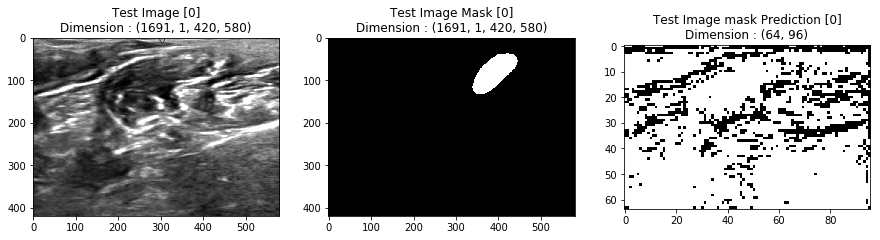

In [102]:
predict_image(0)

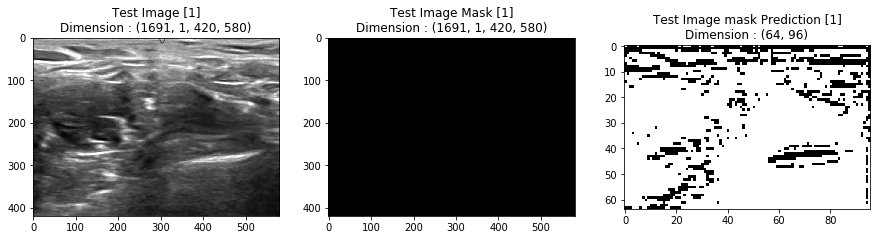

In [103]:
predict_image(1)

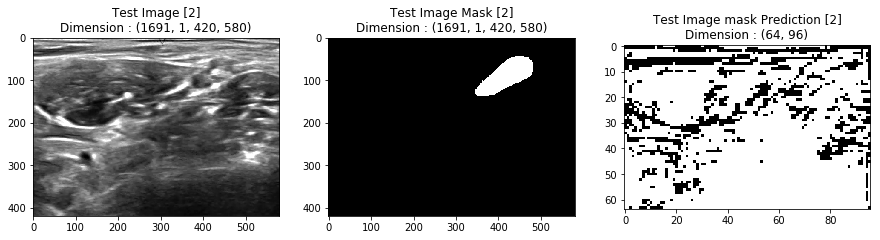

In [104]:
predict_image(2)